In [1]:
!kaggle datasets download -d blastchar/telco-customer-churn
!mv telco-customer-churn.zip data/ 
!unzip data/telco-customer-churn.zip -d data/

/bin/bash: /home/hilbert/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
100%|█████████████████████████████████████████| 172k/172k [00:00<00:00, 452kB/s]
100%|█████████████████████████████████████████| 172k/172k [00:00<00:00, 452kB/s]


In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split


In [124]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.shape)

(7043, 21)


In [125]:
df.head(5).T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


## preprocess

In [126]:
# get feats name uniformity
df.columns = df.columns.str.lower().str.replace(" ", "_")
categoricals = list(df.dtypes[df.dtypes == "object"].index)
for c in categoricals:
    df[c] = df[c].str.lower().str.replace(" ", "_")

In [127]:
# covert object 'totalcharges' to numeric
df.totalcharges = pd.to_numeric(df.totalcharges, errors="coerce")
df.totalcharges = df.totalcharges.fillna(0)

In [128]:
# encode target
df.churn = (df.churn == "yes").astype(int)

In [129]:
df_full_train, dfts = train_test_split(df, test_size=0.2, random_state=1)
dftr, dfvl = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(dftr.shape, dfvl.shape, dfts.shape)

(4225, 21) (1409, 21) (1409, 21)


In [130]:
dftr = dftr.reset_index(drop=True)
dfvl = dfvl.reset_index(drop=True)
dfts = dfts.reset_index(drop=True)

In [131]:
ytr = dftr.churn
yvl = dfvl.churn
yts = dfts.churn

In [132]:
del dftr["churn"]
del dfvl["churn"] 
del dfts["churn"]

## eda

In [133]:
df_full_train.reset_index(drop=True, inplace=True)

In [134]:
df_full_train.isna().sum().sum()

0

In [135]:
df_full_train.churn.value_counts(normalize=True)

0    0.730032
1    0.269968
Name: churn, dtype: float64

In [136]:
global_churn_rate = df_full_train.churn.mean()
round(global_churn_rate, 2)

0.27

In [137]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [138]:
numerical = ['tenure','monthlycharges','totalcharges']
categorical = [x for x in df if (x not in numerical) & (x not in ['customerid', 'churn'])]

## feature importance: churn ratio

In [139]:
(df_full_train[df_full_train.gender == "female"].churn.mean(),
df_full_train[df_full_train.gender == "male"].churn.mean())

(0.27682403433476394, 0.2632135306553911)

In [140]:
(df_full_train[df_full_train.partner == "yes"].churn.mean(),
 df_full_train[df_full_train.partner == "no"].churn.mean())

(0.20503330866025166, 0.3298090040927694)

In [141]:
from IPython.display import display

for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(["mean", "count"])
    df_group["diff"] = df_group["mean"] - global_churn_rate
    df_group["risk"] = df_group["mean"] / global_churn_rate
    display(df_group)

gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208


partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472


dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651


phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412


multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948


internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201


onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570


onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660


deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480


techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390


streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328


streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182


contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730


paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560


paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


## feature importance: mutual info

In [142]:
(mutual_info_score(df_full_train.churn, df_full_train.contract),
 mutual_info_score(df_full_train.churn, df_full_train.gender))

(0.0983203874041556, 0.0001174846211139946)

In [143]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

df_full_train[categorical].apply(mutual_info_churn_score).sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

## feature importance: correlation

In [144]:
df_full_train[numerical].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

## ohe

In [145]:
train_dicts = dftr[categorical+numerical].to_dict(orient="records")
dv = DictVectorizer(sparse=False)
xtr = dv.fit_transform(train_dicts)

In [146]:
val_dicts = dfvl[categorical+numerical].to_dict(orient="records")
xvl = dv.transform(val_dicts)

In [147]:
print(dv.feature_names_[:20])

['contract=month-to-month', 'contract=one_year', 'contract=two_year', 'dependents=no', 'dependents=yes', 'deviceprotection=no', 'deviceprotection=no_internet_service', 'deviceprotection=yes', 'gender=female', 'gender=male', 'internetservice=dsl', 'internetservice=fiber_optic', 'internetservice=no', 'monthlycharges', 'multiplelines=no', 'multiplelines=no_phone_service', 'multiplelines=yes', 'onlinebackup=no', 'onlinebackup=no_internet_service', 'onlinebackup=yes']


## logreg

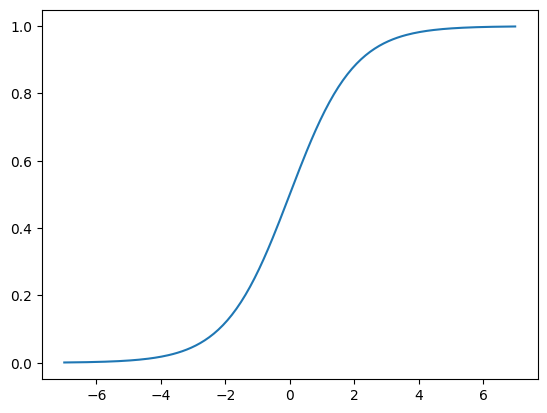

In [148]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-7, 7, 200)
plt.plot(z, sigmoid(z));

In [149]:
def linear_regression(xi):
    score = w0
    for j in range(len(w)):
        score = score + xi[j] * w[j]
    result = sigmoid(score)
    
    return result

In [150]:
model= LogisticRegression()
model.fit(xtr, ytr)
model.coef_[0].round(3), model.intercept_.round(3)

(array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
        -0.034, -0.073, -0.335,  0.316, -0.089,  0.004, -0.258,  0.141,
         0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
         0.124, -0.166,  0.058, -0.087, -0.032,  0.07 , -0.059,  0.141,
        -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
         0.213, -0.089, -0.232, -0.07 ,  0.   ]),
 array([-0.109]))

In [151]:
ypred = model.predict_proba(xvl)[:,1]

In [152]:
churn_decision = (ypred >= 0.5)
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1])

In [153]:
df_pred = pd.DataFrame()
df_pred["probability"] = ypred
df_pred["prediction"] = churn_decision.astype(int)
df_pred["actual"] = yvl
df_pred["correct"] = df_pred["prediction"] == df_pred["actual"]
print((yvl == churn_decision).mean())
df_pred

0.8034066713981547


,probability,prediction,actual,correct
0,0.008997,0,0,True
1,0.204526,0,0,True
2,0.212224,0,0,True
3,0.543051,1,1,True
4,0.213786,0,0,True
...,...,...,...,...
1404,0.313675,0,0,True
1405,0.039360,0,1,False
1406,0.136394,0,0,True
1407,0.799772,1,1,True


## interpretation

In [154]:
dict(zip(dv.feature_names_, model.coef_[0].round(3)))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.316,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.07,
 

## using the model

In [155]:
test_dicts = dfts[categorical+numerical].to_dict(orient="records")
xts = dv.transform(test_dicts)
ypred = model.predict_proba(xts)[:, 1]
churn_decision = (ypred >= 0.5)
(churn_decision == yts).mean()

0.808374733853797

In [163]:
customer = test_dicts[1]
customer

{'gender': 'female',
 'seniorcitizen': 1,
 'partner': 'no',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'no',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'bank_transfer_(automatic)',
 'tenure': 66,
 'monthlycharges': 102.4,
 'totalcharges': 6471.85}

In [164]:
model.predict_proba(dv.transform([customer])), yts[10]

(array([[0.88141214, 0.11858786]]), 0)